# 1.0 Imports

In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random as rand

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 1.1 Data Acquisition and Preprocessing

## 1.1.1 Load the Dataframe in using Dask

In [ ]:
collisionurls = {
    '2021': 'https://firebasestorage.googleapis.com/v0/b/aiq-bot.appspot.com/o/20210604_CollisionRecords.txt?alt=media&token=782c69aa-081b-421d-8399-a3e028bd643b',
}

In [ ]:
features = [
    'CASE_ID', # useful

    'COLLISION_TIME', # predictor
    'DAY_OF_WEEK',
    'LIGHTING',
    'WEATHER_1',
    'WEATHER_2',
    'ROAD_SURFACE',
    'ROAD_COND_1',
    'MVIW',
    'STWD_VEHTYPE_AT_FAULT',

    'COLLISION_SEVERITY', # target
]

In [ ]:
ddf = dd.read_csv(
    collisionurls['2021'],
    dtype = {
        'CASE_ID':               object,

        'COLLISION_TIME':        object,
        'DAY_OF_WEEK':           object,
        'LIGHTING':              object,
        'WEATHER_1':             object,
        'WEATHER_2':             object,
        'ROAD_SURFACE':          object,
        'ROAD_COND_1':           object,
        'MVIW':                  object,
        'STWD_VEHTYPE_AT_FAULT': object,

        'COLLISION_SEVERITY':    object,
    },
    usecols = features,
)

In [ ]:
rawdf = ddf.compute()

In [ ]:
rawdf.drop( # remove malformed row
    rawdf[rawdf.COLLISION_SEVERITY == 'N'].index,
    inplace=True,
)
rawdf.drop( # remove malformed row
    rawdf[rawdf.LIGHTING == 'G'].index,
    inplace=True,
)

In [ ]:
rawdf.replace('-', pd.NA, inplace=True)
rawdf.replace('<NA>', pd.NA, inplace=True)

In [ ]:
rawdf

,CASE_ID,COLLISION_TIME,DAY_OF_WEEK,WEATHER_1,WEATHER_2,COLLISION_SEVERITY,MVIW,ROAD_SURFACE,ROAD_COND_1,LIGHTING,STWD_VEHTYPE_AT_FAULT
0,0081715,0745,6,B,<NA>,0,C,A,H,A,<NA>
1,0726202,0250,7,A,<NA>,0,I,A,H,C,A
2,3858022,1711,2,A,<NA>,0,C,A,H,A,J
3,3899441,0145,6,A,<NA>,0,I,A,H,D,A
4,3899442,1020,1,C,<NA>,0,C,B,H,A,A
...,...,...,...,...,...,...,...,...,...,...,...
202753,9271440,2142,2,A,<NA>,0,C,A,H,C,A
202754,9271441,1720,1,A,<NA>,0,C,A,H,A,A
202755,9271445,1501,4,A,<NA>,0,C,A,H,A,A
202756,9277562,2023,4,A,<NA>,4,C,A,H,B,<NA>


## 1.1.2 Create a New Dataframe With Our Predictor Variables


In [ ]:
Xdf = rawdf[['CASE_ID']].copy()

Note: there seems to be an error in the source files, where collision times that should be written 2400 are reported as 2500

In [ ]:
lis = rawdf['COLLISION_TIME'].astype(int).unique()
lis.sort()
lis # temporary var not used anywhere else

array([   0,    1,    2, ..., 2358, 2359, 2500])

In [ ]:
def coltime_to_minute(coltime): # convert COLLISION_TIME integer to
                                # number of minutes since midnight
    coltime = int(coltime)

    if coltime > 2359: # time is unknown, we will put a random number to preserve distribution
      return rand.randrange(0, 1440)

    minute = coltime % 100 # last two digits
    hour = coltime // 100 # first two digits
    return int(60*hour + minute)

rand.seed(42)
Xdf['Minute'] = rawdf['COLLISION_TIME'].apply(coltime_to_minute)
Xdf['Minute']

,Minute
0,465
1,170
2,1031
3,105
4,620
...,...
202753,1302
202754,1040
202755,901
202756,1223


In [ ]:
rawdf.DAY_OF_WEEK.value_counts(dropna=False)

,count
DAY_OF_WEEK,
5,866324
4,789268
3,779758
2,774463
1,740306
6,722707
7,620483


In [ ]:
Xdf['Day'] = rawdf['DAY_OF_WEEK'].map({
    '1': '1-Monday',
    '2': '2-Tuesday',
    '3': '3-Wednesday',
    '4': '4-Thursday',
    '5': '5-Friday',
    '6': '6-Saturday',
    '7': '7-Sunday',
})
Xdf['Day'].value_counts()

,count
Day,
5-Friday,866324
4-Thursday,789268
3-Wednesday,779758
2-Tuesday,774463
1-Monday,740306
6-Saturday,722707
7-Sunday,620483


In [ ]:
rawdf.LIGHTING.value_counts(dropna=False)

,count
LIGHTING,
A,3480727
C,1148058
D,439735
B,187907
<NA>,24211
E,12670
,1


In [ ]:
Xdf['Lighting'] = rawdf['LIGHTING'].map({
    'A': 'a-Daylight',
    'B': 'b-Dusk/Dawn',
    'C': 'c-Dark - Lit',
    'D': 'd-Dark - Unlit',
    'E': 'e-Dark - Lights Broken',
}).fillna('NA')
Xdf['Lighting'].value_counts(dropna=False)

,count
Lighting,
a-Daylight,3480727
c-Dark - Lit,1148058
d-Dark - Unlit,439735
b-Dusk/Dawn,187907
NA,24212
e-Dark - Lights Broken,12670


In [ ]:
rawdf.WEATHER_2.value_counts(dropna=False)

,count
WEATHER_2,
<NA>,5150811
C,108450
B,12068
G,11415
F,3605
D,3499
E,3460
N,1


In [ ]:
weathermap = {
    'A': 'a-Clear',
    'B': 'b-Cloudy',
    'C': 'c-Raining',
    'D': 'd-Snowing',
    'E': 'e-Fog',
    'F': 'f-Other',
    'G': 'g-Wind',
}
Xdf['Weather 1'] = rawdf['WEATHER_1'].map(weathermap).fillna('UNKNOWN')
Xdf['Weather 2'] = rawdf['WEATHER_2'].map(weathermap).fillna(Xdf['Weather 1'])

In [ ]:
Xdf[['Weather 1', 'Weather 2']].value_counts(dropna=False).unstack()

Weather 2,UNKNOWN,a-Clear,b-Cloudy,c-Raining,d-Snowing,e-Fog,f-Other,g-Wind
Weather 1,,,,,,,,
UNKNOWN,19551.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a-Clear,NaN,4414538.0,12068.0,1464.0,144.0,414.0,1643.0,7943.0
b-Cloudy,NaN,NaN,515924.0,106986.0,2931.0,2342.0,1282.0,1715.0
c-Raining,NaN,NaN,NaN,168847.0,424.0,587.0,522.0,1434.0
d-Snowing,NaN,NaN,NaN,NaN,6274.0,117.0,35.0,70.0
e-Fog,NaN,NaN,NaN,NaN,NaN,17753.0,123.0,62.0
f-Other,NaN,NaN,NaN,NaN,NaN,NaN,5844.0,191.0
g-Wind,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2081.0


In [ ]:
rawdf.ROAD_SURFACE.value_counts(dropna=False)

,count
ROAD_SURFACE,
A,4819928
B,411790
<NA>,38162
C,19080
D,4243
H,102
,2
I,1
J,1


In [ ]:
Xdf['Road Surface'] = rawdf['ROAD_SURFACE'].map({
    'A': 'a-Dry',
    'B': 'b-Wet',
    'C': 'c-Snowy',
    'D': 'd-Slippery',
}).fillna('Other')
Xdf['Road Surface'].value_counts(dropna=False)

,count
Road Surface,
a-Dry,4819928
b-Wet,411790
Other,38268
c-Snowy,19080
d-Slippery,4243


In [ ]:
rawdf.ROAD_COND_1.value_counts(dropna=False).sort_index()

,count
ROAD_COND_1,
A,16144
B,9394
C,18482
D,90882
E,5145
F,3640
G,18429
H,5094949
<NA>,36244


In [ ]:
Xdf['Road Cond'] = rawdf['ROAD_COND_1'].map({
    'A': 'a-Holes',
    'B': 'b-Loose Material',
    'C': 'c-Obstruction',
    'D': 'd-Construction',
    'E': 'e-Narrow',
    'F': 'f-Flooded',
    'G': 'g-Other',
    'H': 'h-Normal',
}).fillna('h-Normal')
Xdf['Road Cond'].value_counts(dropna=False)

,count
Road Cond,
h-Normal,5131193
d-Construction,90882
c-Obstruction,18482
g-Other,18429
a-Holes,16144
b-Loose Material,9394
e-Narrow,5145
f-Flooded,3640


In [ ]:
rawdf.MVIW.value_counts(dropna=False).sort_index()

,count
MVIW,
0,5
2,139
3,1
4,3
7,3
8,192
9,12
A,138639
B,163425


In [ ]:
vehiclemap = {
    'A': 'a-Not a Collision',
    'B': 'b-Pedestrian',
    'C': 'c-Vehicle on Same Roadway',
    'D': 'd-Vehicle on Other Roadway',
    'E': 'e-Vehicle parked',
    'F': 'f-Train',
    'G': 'g-Bike',
    'H': 'h-Animal',
    'I': 'i-Fixed Object',
    'J': 'j-Other Object',
}
Xdf['Collision Target'] = rawdf['MVIW'].map(vehiclemap).fillna('UNKNOWN')
Xdf['Collision Target'].value_counts(dropna=False)

,count
Collision Target,
c-Vehicle on Same Roadway,3408447
i-Fixed Object,829636
e-Vehicle parked,407868
b-Pedestrian,163425
g-Bike,140299
a-Not a Collision,138639
j-Other Object,114027
d-Vehicle on Other Roadway,37108
UNKNOWN,27730


In [ ]:
rawdf.STWD_VEHTYPE_AT_FAULT.value_counts(dropna=False).sort_index()

,count
STWD_VEHTYPE_AT_FAULT,
22,1
A,3274023
B,6016
C,102107
D,550249
E,18961
F,61160
G,73644
H,8591


In [ ]:
stwdvehiclemap = {
    'A': 'a-Car',
    'B': 'b-Car with Trailer',
    'C': 'c-Motorcycle',
    'D': 'd-Pickup',
    'E': 'e-Pickup with Trailer',
    'F': 'f-Truck',
    'G': 'g-Truck with Trailer',
    'H': 'h-School Bus',
    'I': 'i-Bus',
    'J': 'j-Emergency Vehicle',
    'K': 'k-Construction Vehicle',
    'L': 'l-Bike',
    'M': 'm-Other',
    'N': 'n-Pedestrian',
    'O': 'o-Moped',
}
Xdf['Vehicle At Fault'] = rawdf['STWD_VEHTYPE_AT_FAULT']\
                          .map(stwdvehiclemap).fillna('x-NA')
Xdf['Vehicle At Fault'].value_counts(dropna=False)

,count
Vehicle At Fault,
a-Car,3274023
x-NA,991073
d-Pickup,550249
c-Motorcycle,102107
l-Bike,88517
g-Truck with Trailer,73644
f-Truck,61160
n-Pedestrian,58072
j-Emergency Vehicle,30990


In [ ]:
Xdf.set_index('CASE_ID', inplace=True)
Xdf

,Minute,Day,Lighting,Weather 1,Weather 2,Road Surface,Road Cond,Collision Target,Vehicle At Fault
CASE_ID,,,,,,,,,
0081715,465,6-Saturday,a-Daylight,b-Cloudy,b-Cloudy,a-Dry,h-Normal,c-Vehicle on Same Roadway,x-NA
0726202,170,7-Sunday,c-Dark - Lit,a-Clear,a-Clear,a-Dry,h-Normal,i-Fixed Object,a-Car
3858022,1031,2-Tuesday,a-Daylight,a-Clear,a-Clear,a-Dry,h-Normal,c-Vehicle on Same Roadway,j-Emergency Vehicle
3899441,105,6-Saturday,d-Dark - Unlit,a-Clear,a-Clear,a-Dry,h-Normal,i-Fixed Object,a-Car
3899442,620,1-Monday,a-Daylight,c-Raining,c-Raining,b-Wet,h-Normal,c-Vehicle on Same Roadway,a-Car
...,...,...,...,...,...,...,...,...,...
9271440,1302,2-Tuesday,c-Dark - Lit,a-Clear,a-Clear,a-Dry,h-Normal,c-Vehicle on Same Roadway,a-Car
9271441,1040,1-Monday,a-Daylight,a-Clear,a-Clear,a-Dry,h-Normal,c-Vehicle on Same Roadway,a-Car
9271445,901,4-Thursday,a-Daylight,a-Clear,a-Clear,a-Dry,h-Normal,c-Vehicle on Same Roadway,a-Car


## 1.1.3 Create a new dataframe with our target variable

In [ ]:
rawdf.COLLISION_SEVERITY.value_counts(dropna=False)

,count
COLLISION_SEVERITY,
0,3153117
4,1315929
3,651040
2,135511
1,37712


In [ ]:
Ydf = rawdf[['CASE_ID']].copy()

In [ ]:
Ydf['Severity'] = rawdf['COLLISION_SEVERITY'].map({
    '0': '5 - Property Dmg Only',
    '4': '4 - Complaint of Pain',
    '3': '3 - Visible Injury',
    '2': '2 - Severe Injury',
    '1': '1 - Death',
}).fillna('BIG PROBLEM')
Ydf['Severity'].value_counts(dropna=False)

,count
Severity,
5 - Property Dmg Only,3153117
4 - Complaint of Pain,1315929
3 - Visible Injury,651040
2 - Severe Injury,135511
1 - Death,37712


In [ ]:
Ydf.set_index('CASE_ID', inplace=True)
Ydf

,Severity
CASE_ID,
0081715,5 - Property Dmg Only
0726202,5 - Property Dmg Only
3858022,5 - Property Dmg Only
3899441,5 - Property Dmg Only
3899442,5 - Property Dmg Only
...,...
9271440,5 - Property Dmg Only
9271441,5 - Property Dmg Only
9271445,5 - Property Dmg Only


In [ ]:
df = Xdf.join(Ydf)

# 1.2 Exploratory Data Analysis

## 1.2.1 Class Balance

<Axes: title={'center': 'Distribution of Severity Levels'}, ylabel='count'>

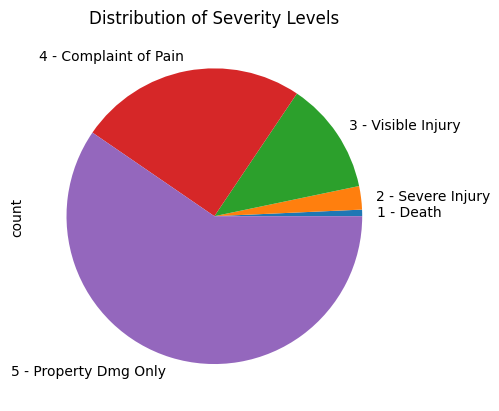

In [ ]:
Ydf.Severity.value_counts().sort_index().plot.pie(
    title = 'Distribution of Severity Levels'
)

We see here that the worse severity levels are less represented in our dataframe: we have pretty bad class imbalance.

## 1.2.2 Correlation Between Categorical Variables and Severity

### 1.2.2.0 Helper Functions

In [ ]:
# for each pairing of X_feature Y_feature levels,
# computes prob(Y_level | X_level) / prob(Y_level)
# takes the natural log ([0, inf] -> [-inf, inf])
# and plots this on a bar plot

def get_plotct(xf, yf):
    ct = pd.crosstab(df[xf], df[yf])

    yprob_givenx = ct.div(df[xf].value_counts(), axis=0)
    yprob = df[yf].value_counts() / df.shape[0]

    return yprob_givenx.div(yprob, axis=1)

def plot_catvars(xf, yf, xlevels=[]):
    plotct = get_plotct(xf, yf)

    if (len(xlevels) != 0):
        plotct = plotct.loc[xlevels]

    np.log(plotct).plot.bar(
        title = 'Correlation between each ' + xf + ' level and ' + yf,
        ylabel = 'ln[ P('+yf+'|'+xf+') / P('+yf+') ]',
    )

### 1.2.2.1 Day

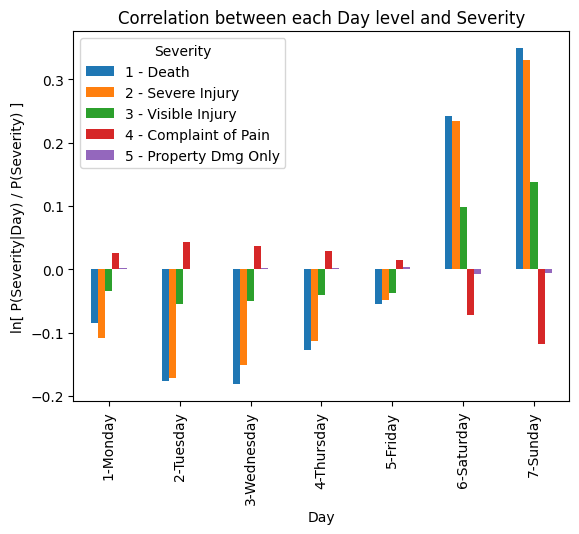

In [ ]:
plot_catvars('Day', 'Severity')

We can see that the crashes that occur on Saturday and Sunday are SIGNIFICANTLY more probable to result in death or severe injury.

### 1.2.2.2 Weather

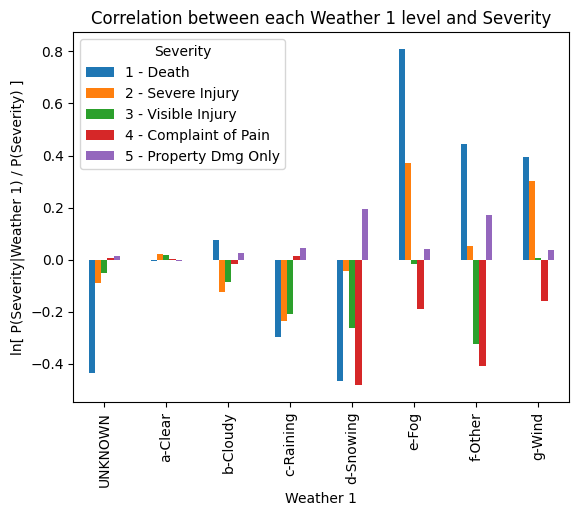

In [ ]:
plot_catvars('Weather 1', 'Severity')

We can see that weather conditions like fog and wind make crashes more dangerous. Somewhat surprisingly however, crashes that occur in the Rain or Snow have a lower chance to result in death. Maybe this is because most Rain or Snow crashes are actually slides off of a road, and not collisions with other vehicles. Let's investigate:

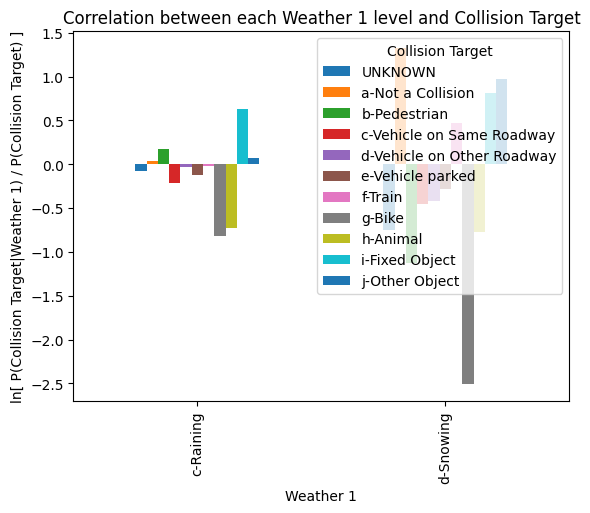

In [ ]:
plot_catvars('Weather 1', 'Collision Target', xlevels=['c-Raining', 'd-Snowing'])

It's a little hard to see, but the rain has disproportionately more collisions with fixed objects, and snow conditions have more non-collisions and object collisions. This shines a bit more light on the strangely low chance of death in the snow and rain.

### 1.2.2.3 Lighting

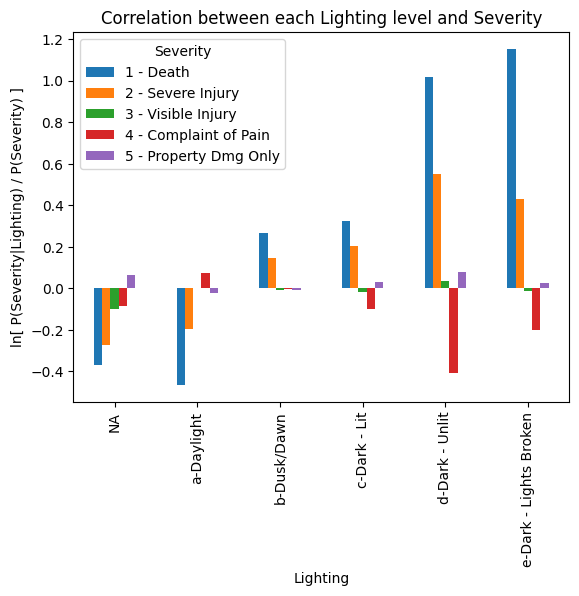

In [ ]:
plot_catvars('Lighting', 'Severity')

We can see that when it is Dark, and ESPECIALLY when the street is unlit in the darkness, we have a higher chance of death.

### 1.2.2.4 Collision Target

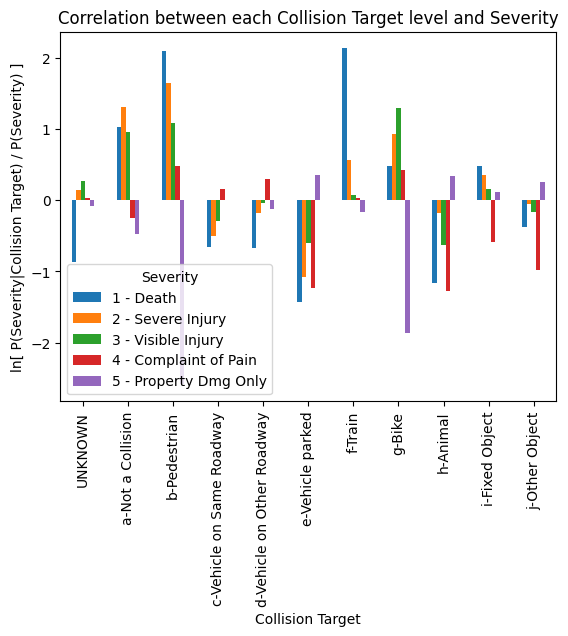

In [ ]:
plot_catvars('Collision Target', 'Severity')

We can see that crashes with Pedestrians, Trains, Fixed Objects, and Non-Collisions (slide off of cliff etc) have a much higher chance of death.

Collisions with parked vehicles have really low chance of death, probably because they usually occur in parking lots at low speed.

### 1.2.2.5 Vehicle At Fault

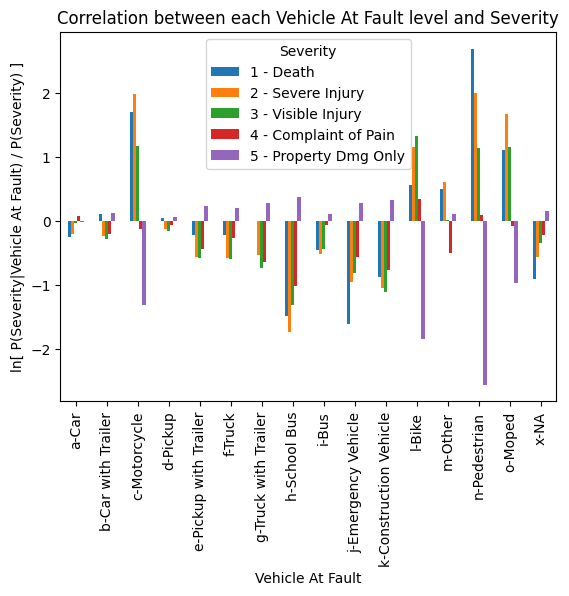

In [ ]:
plot_catvars('Vehicle At Fault', 'Severity')

The highest chance of death occurs when the person at fault is either a Motorcyle, Bike, Pedestrian, or Moped. This meets our natural expectations.

## 1.2.3 Correllation between Minute of Day and Severity

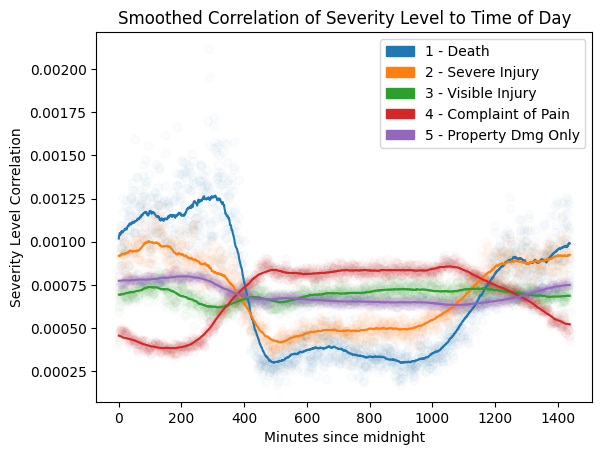

In [ ]:
matrix = get_plotct('Minute', 'Severity')

fig = plt.figure()

colors = {
    '1 - Death': 'tab:blue',
    '2 - Severe Injury': 'tab:orange',
    '3 - Visible Injury': 'tab:green',
    '4 - Complaint of Pain': 'tab:red',
    '5 - Property Dmg Only': 'tab:purple',
}

def smooth(list, win_size):
    window = []
    result = []

    for i in range(0, win_size):
        window.append(list[i])

    for i in range(0, len(list)):
        if (i + win_size < len(list)):
            window.append(list[i + win_size])

        if (i > win_size):
            window.remove(window[0])

        result.append(sum(window)/len(window))

    return result

for col in matrix.columns:
    plt.scatter(
        x = matrix.index,
        y = smooth(matrix[col] / matrix[col].sum(), 1),
        color=colors[col],
        alpha = 0.02,
    )
    plt.plot(
        matrix.index,
        smooth(matrix[col] / matrix[col].sum(), 50),
        color=colors[col],
    )

plt.legend(handles=[
    mpatches.Patch(color=colors[severity], label=severity)
    for severity in colors.keys()
])

plt.title('Smoothed Correlation of Severity Level to Time of Day')
plt.xlabel('Minutes since midnight')
plt.ylabel('Severity Level Correlation')

fig.show()

(this plot is the same as previous, just modified to work with a numeric independent variable: so we have a line plot instead of bar plot. However the numbers are still the same)

The moment that the death chance swiftly goes down is around 6:00 AM. On This plot we can basically just see that in the early morning when it is still dark, crashes that occur are more likely to result in death, and during the day (6 AM - 4 PM) crashes are less likely to result in death.

# 1.3 Classifier Model Tuning

## 1.3.0 Create General Column Transformer for Predictors, and sample the dataframe

A short function to split data while maximizing class balance. (We use a small subset of the dataframe for large gridsearch, but we want to make sure our model sees all of the target levels)

In [ ]:
def sample_df(frac):
    result_df = pd.DataFrame()

    n = int(df.shape[0]*frac / df['Severity'].nunique())

    for sev_lvl in df['Severity'].unique():
        lvl_df = df[df['Severity'] == sev_lvl]

        result_df = pd.concat([
            lvl_df.sample(n=min(n, lvl_df.shape[0]), random_state=42),
            result_df
        ])

    return result_df

In [ ]:
df_0001 = sample_df(0.0001)
df_001 = sample_df(0.001)
df_01 = sample_df(0.01)
df_1 = sample_df(0.1)

In [ ]:
coltrans = make_column_transformer(
    (
        StandardScaler(),
        ['Minute'],
    ),
    (
        OneHotEncoder(handle_unknown='ignore'),
        ['Day', 'Lighting', 'Weather 1', 'Weather 2', 'Road Surface',
         'Road Cond', 'Collision Target', 'Vehicle At Fault'],
    ),
    remainder = 'drop',
)

## 1.3.1 K Nearest Neighbors Gridsearch

### 1.3.1.0 Helper Functions

A handy dandy function to plot the results of the gridsearch: K & P values vs F1

In [ ]:
def plot_knn_results(gs_obj, title, vlines = [], hlines = []):
    fig = plt.figure()

    colormap = {
        1: 'tab:blue',
        2: 'tab:red',
    }

    x_dat = pd.Series(
        gs_obj.cv_results_['param_kneighborsclassifier__n_neighbors'].data
    )
    y_dat = pd.Series(
        gs_obj.cv_results_['mean_test_score']
    )
    col_dat = pd.Series(
        gs_obj.cv_results_['param_kneighborsclassifier__p'].data
    ).map(colormap)

    x_mid = (x_dat.max() + x_dat.min()) / 2
    y_mid = (y_dat.max() + y_dat.min()) / 2

    plt.scatter(x=x_dat, y=y_dat, color=col_dat)

    for xval in vlines:
        plt.plot([xval] * y_dat.shape[0], (y_dat-y_mid)*1.1+y_mid,
                 color='black', alpha=0.5)

    for yval in hlines:
        plt.plot((x_dat-x_mid)*1.1+x_mid, [yval] * x_dat.shape[0],
                 color='black', alpha=0.5)

    plt.title(title)
    plt.xlabel('K Hyperparameter')
    plt.ylabel('Score')
    plt.figtext(0,0,'Blue: Manhattan Distance\nRed: Euclidian Distance')

    fig.show()

In [ ]:
def knn_gridsearch(krange, score = 'f1_macro', cv = 2):
    return GridSearchCV(
        estimator = make_pipeline(
            coltrans, KNeighborsClassifier(n_jobs = -1)
        ),
        param_grid = {
            'kneighborsclassifier__n_neighbors': krange,
           'kneighborsclassifier__p': [1, 2],
        },
        scoring = score,
        cv = cv,
        n_jobs = -1,
        error_score='raise'
    )

### 1.3.1.1 Broad KNN GridSearch

In [ ]:
# 1 min runtime

gs_knn_broad = knn_gridsearch(range(1,200), cv = 5)

gs_knn_broad.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

gs_knn_broad.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


{'kneighborsclassifier__n_neighbors': 24, 'kneighborsclassifier__p': 2}

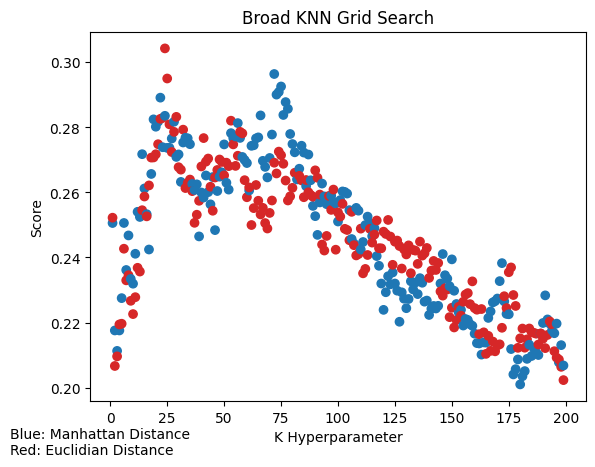

In [ ]:
plot_knn_results(gs_knn_broad, 'Broad KNN Grid Search')

From this plot we can see that the best values of K are somewhere between 20 and 85. We will now conduct a finer grid search on a larger subset of the dataframe.

### 1.3.1.2 Fine KNN Gridsearch

In [ ]:
# 9 minute runtime

gs_knn_fine = knn_gridsearch(range(10,95), cv = 5)

gs_knn_fine.fit(df_001[Xdf.columns], df_001[Ydf.columns])

gs_knn_fine.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


{'kneighborsclassifier__n_neighbors': 56, 'kneighborsclassifier__p': 1}

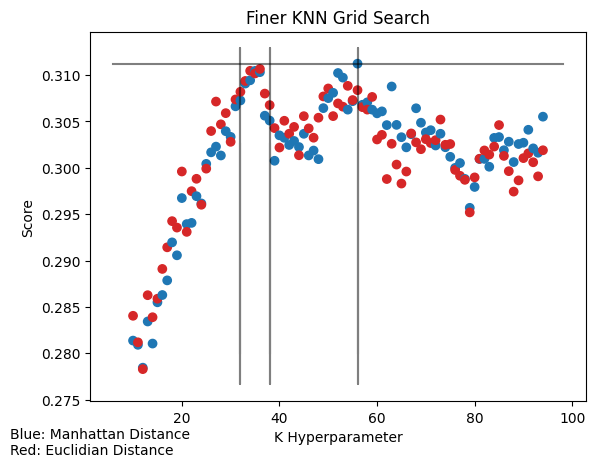

In [ ]:
plot_knn_results(
    gs_knn_fine, 'Finer KNN Grid Search',
    vlines=[32, 38, gs_knn_fine.best_params_['kneighborsclassifier__n_neighbors']],
    hlines=[gs_knn_fine.best_score_]
)

Although the best f1 score was reached at K=56, we can see on the plot that there is a peak at K=36 of similar height. The K=56 point looks a lot like an outlier, while K=36 has a lot more high-scoring points around it. So, we will conduct our final grid search in that range.

### 1.3.1.3 Finest KNN gridsearch

In [ ]:
# 1 minute runtime

gs_knn_finest = knn_gridsearch(range(32,38), cv = 10)

gs_knn_finest.fit(df_001[Xdf.columns], df_001[Ydf.columns])

(gs_knn_finest.best_params_, gs_knn_finest.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


({'kneighborsclassifier__n_neighbors': 36, 'kneighborsclassifier__p': 1},
 0.31092119486596503)

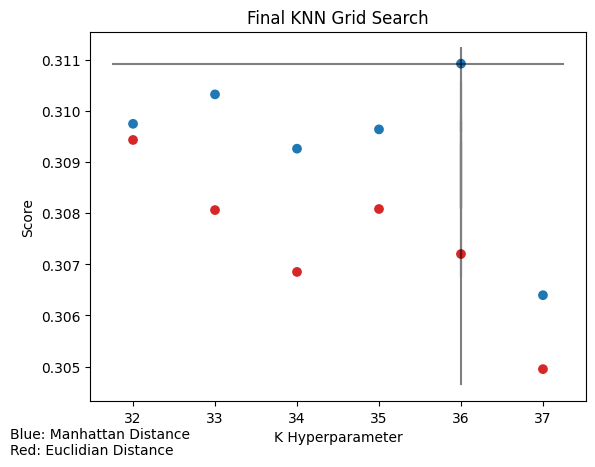

In [ ]:
plot_knn_results(
    gs_knn_finest, 'Final KNN Grid Search',
    vlines=[gs_knn_finest.best_params_['kneighborsclassifier__n_neighbors']],
    hlines=[gs_knn_finest.best_score_]
)

### **1.3.1.4 FINAL KNN CONCLUSIONS**

Optimal parameters:
- K = 36
- P = 1

Its F1_Macro score is 0.311

In [ ]:
# 11 s runtime

gs_knn_final = knn_gridsearch(range(36,36+1), cv = 10)

gs_knn_final.fit(df_001[Xdf.columns], df_001[Ydf.columns])

(gs_knn_final.best_params_, gs_knn_final.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


({'kneighborsclassifier__n_neighbors': 36, 'kneighborsclassifier__p': 1},
 0.31092119486596503)

## 1.3.2 Support Vector Machine GridSearch

### 1.3.2.0 Setup Helper Functions

In [ ]:
def frange(min, max, step):
  while (min < max):
    yield min
    min += step

def svm_gridsearch(grid, cmin, cmax, n=10, score = 'f1_macro', cv = 2):
    grid.update({
        'svc__C': list(frange(cmin, cmax, (cmax-cmin)/n)),
    })
    return GridSearchCV(
        estimator = make_pipeline(
            coltrans, SVC()
        ),
        param_grid = grid,
        scoring = score,
        cv = cv,
        n_jobs = -1,
        error_score='raise'
    )

In [ ]:
def plot_svm_results(gs_obj, title, colvar, colmap, vlines = [], hlines = []):
    fig = plt.figure()

    x_dat = pd.Series(
        gs_obj.cv_results_['param_svc__C'].data
    )
    y_dat = pd.Series(
        gs_obj.cv_results_['mean_test_score']
    )
    col_dat = pd.Series(
        gs_obj.cv_results_[colvar].data
    ).map(colmap)

    x_mid = (x_dat.max() + x_dat.min()) / 2
    y_mid = (y_dat.max() + y_dat.min()) / 2

    plt.scatter(x=x_dat, y=y_dat, color=col_dat)

    for xval in vlines + [gs_obj.best_params_['svc__C']]:
        plt.plot([xval] * y_dat.shape[0], (y_dat-y_mid)*1.1+y_mid,
                 color='black', alpha=0.5)

    for yval in hlines + [gs_obj.best_score_]:
        plt.plot((x_dat-x_mid)*1.1+x_mid, [yval] * x_dat.shape[0],
                 color='black', alpha=0.5)

    plt.title(title)
    plt.xlabel('C Hyperparameter')
    plt.ylabel('Score')
    plt.legend(handles=[mpatches.Patch(color='white', label=colvar.split('__')[1])] + [
        mpatches.Patch(color=colmap[key], label=str(key))
        for key in colmap.keys()
    ])

    fig.show()

### 1.3.2.1 SVM: Linear Kernel

In [ ]:
# 2 min runtime

gs_svm_lin = svm_gridsearch(
    {
        'svc__kernel': ['linear'],
        'svc__shrinking': [True, False]
    },
    0.0000001, 1,
    n = 100, cv = 10,
)

gs_svm_lin.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_lin.best_params_, gs_svm_lin.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 0.07000009300000001,
  'svc__kernel': 'linear',
  'svc__shrinking': True},
 0.3167034383924282)

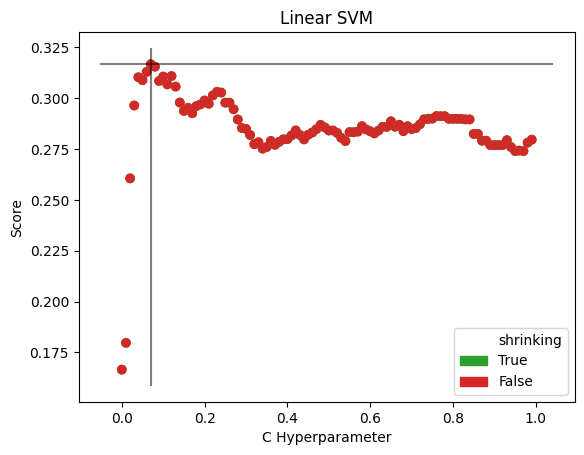

In [ ]:
plot_svm_results(
    gs_svm_lin, 'Linear SVM',
    'param_svc__shrinking', {
        True: 'tab:green',
        False: 'tab:red',
    }
)

We see a peak around C=0.1, lets zoom in. Furthermore, we see the shrinking parameter is not changing things, let's remove that extra variable.

In [ ]:
# 60 second runtime

gs_svm_lin = svm_gridsearch(
    {
        'svc__kernel': ['linear'],
        'svc__shrinking': [True]
    },
    0.055, 0.075,
    n = 100, cv = 10,
)

gs_svm_lin.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_lin.best_params_, gs_svm_lin.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 0.06820000000000012,
  'svc__kernel': 'linear',
  'svc__shrinking': True},
 0.3198515241239985)

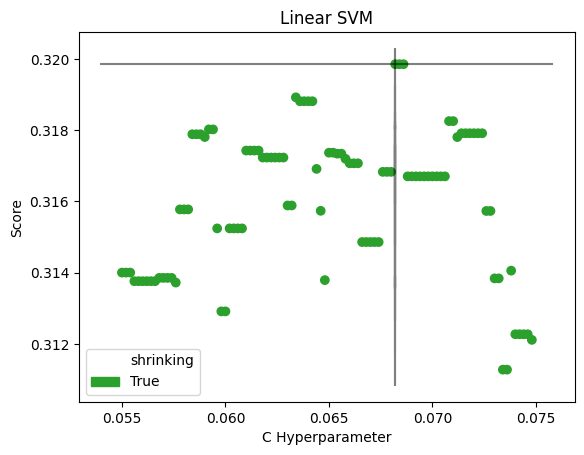

In [ ]:
plot_svm_results(
    gs_svm_lin, 'Linear SVM',
    'param_svc__shrinking', {
        True: 'tab:green',
    }
)

### 1.3.2.2 SVM: Polynomial Kernel (gamma=scale)

In [ ]:
# 19 second runtime

gs_svm_poly_scale = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(1,4),
        'svc__gamma': ['scale'],
    },
    0.00001, 5,
    n = 50,
)

gs_svm_poly_scale.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

gs_svm_poly_scale.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'svc__C': 2.1000058,
 'svc__degree': 1,
 'svc__gamma': 'scale',
 'svc__kernel': 'poly'}

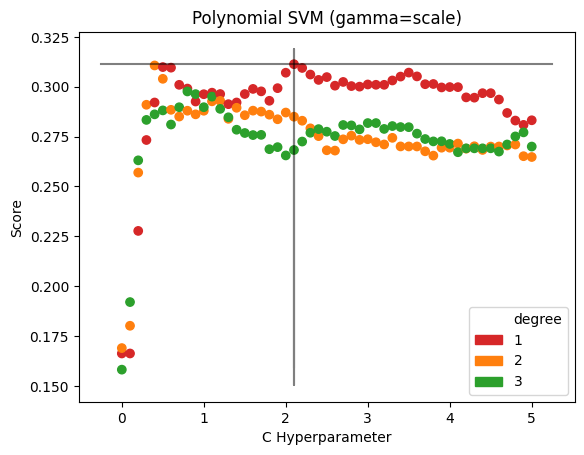

In [ ]:
plot_svm_results(
    gs_svm_poly_scale, 'Polynomial SVM (gamma=scale)',
    'param_svc__degree', {
        1: 'tab:red',
        2: 'tab:orange',
        3: 'tab:green',
    }
)

We can see that the best degree is either 1 or 2. Lets check out the peaks around C=0.5 and C=2.1

In [ ]:
# __ second runtime

gs_svm_poly_scale = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(1,3),
        'svc__gamma': ['scale'],
    },
    0.00001, 1,
    n = 30, cv=10,
)

gs_svm_poly_scale.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_poly_scale.best_params_, gs_svm_poly_scale.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 0.20000800000000002,
  'svc__degree': 2,
  'svc__gamma': 'scale',
  'svc__kernel': 'poly'},
 0.3241599427404226)

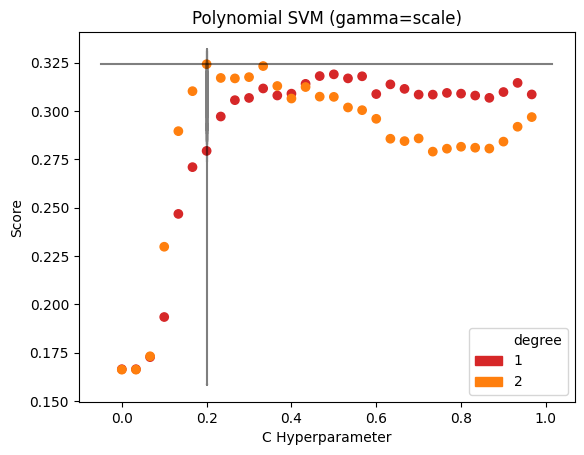

In [ ]:
plot_svm_results(
    gs_svm_poly_scale, 'Polynomial SVM (gamma=scale)',
    'param_svc__degree', {
        1: 'tab:red',
        2: 'tab:orange',
    }
)

Okay, so C=0.2 is very good with degree 2. Now lets look at the C=2.1 peak from before.

In [ ]:
# 40 second runtime

gs_svm_poly_scale = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(1,2),
        'svc__gamma': ['scale'],
    },
    1.7, 2,
    n = 50, cv=10,
)

gs_svm_poly_scale.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_poly_scale.best_params_, gs_svm_poly_scale.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 1.826,
  'svc__degree': 1,
  'svc__gamma': 'scale',
  'svc__kernel': 'poly'},
 0.305852822790661)

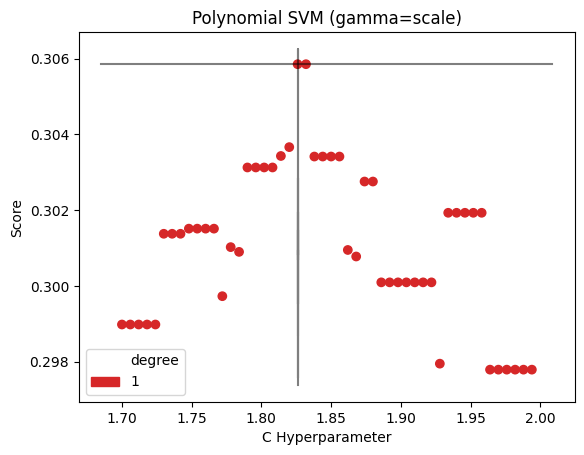

In [ ]:
plot_svm_results(
    gs_svm_poly_scale, 'Polynomial SVM (gamma=scale)',
    'param_svc__degree', {
        1: 'tab:red',
    }
)

While there is definitely a peak here, we get a better score with the C=0.2 peak. Lets ignore this and fully explore that.

In [ ]:
# 60 second runtime

gs_svm_poly_scale = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(2,3),
        'svc__gamma': ['scale'],
    },
    0.31, 0.37,
    n = 100, cv=10,
)

gs_svm_poly_scale.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_poly_scale.best_params_, gs_svm_poly_scale.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 0.3279999999999997,
  'svc__degree': 2,
  'svc__gamma': 'scale',
  'svc__kernel': 'poly'},
 0.3257612099721622)

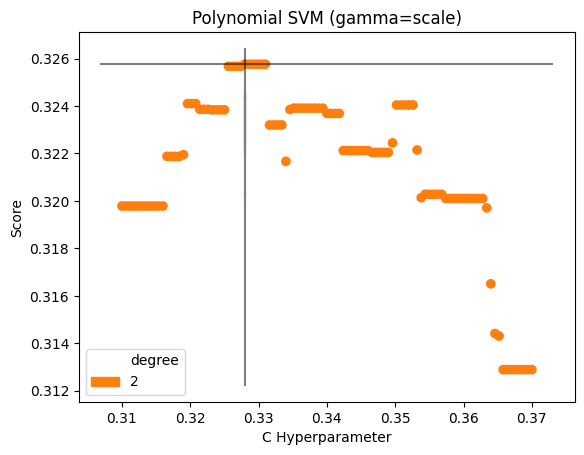

In [ ]:
plot_svm_results(
    gs_svm_poly_scale, 'Polynomial SVM (gamma=scale)',
    'param_svc__degree', {
        2: 'tab:orange',
    }
)

We have found the optimal polynomial model here with gamma=scale

### 1.3.2.3 SVM: Polynomial SVM (gamma=auto)

In [ ]:
# 1 min runtime

gs_svm_poly_auto = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(1,3),
        'svc__gamma': ['auto'],
    },
    0.00001, 20,
    n = 50, cv = 10,
)

gs_svm_poly_auto.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

gs_svm_poly_auto.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'svc__C': 10.400004799999996,
 'svc__degree': 2,
 'svc__gamma': 'auto',
 'svc__kernel': 'poly'}

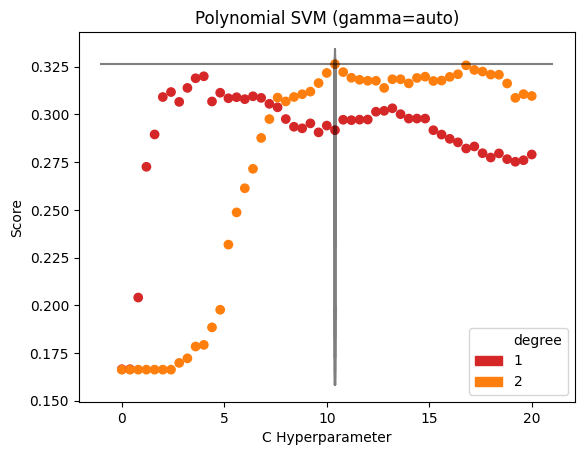

In [ ]:
plot_svm_results(
    gs_svm_poly_auto, 'Polynomial SVM (gamma=auto)',
    'param_svc__degree', {
        1: 'tab:red',
        2: 'tab:orange',
    }
)

We see a clear peak at C=10 with degree 2, lets zoom in

In [ ]:
# 30 second runtime

gs_svm_poly_auto = svm_gridsearch(
    {
        'svc__kernel': ['poly'],
        'svc__degree': range(2,3),
        'svc__gamma': ['auto'],
    },
    10, 11,
    n = 50, cv = 10,
)

gs_svm_poly_auto.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_poly_auto.best_params_, gs_svm_poly_auto.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 10.45999999999999,
  'svc__degree': 2,
  'svc__gamma': 'auto',
  'svc__kernel': 'poly'},
 0.3280169993943025)

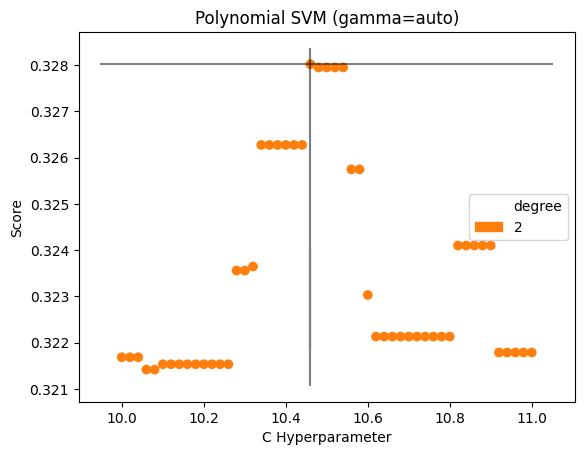

In [ ]:
plot_svm_results(
    gs_svm_poly_auto, 'Polynomial SVM (gamma=auto)',
    'param_svc__degree', {
        2: 'tab:orange',
    }
)

This model with gamma=auto is better than the one with gamma=scale

### 1.3.2.4 SVM: rbf Kernel

In [ ]:
# 19 second runtime

gs_svm_rbf = svm_gridsearch(
    {
        'svc__kernel': ['rbf'],
        'svc__gamma': ['auto', 'scale'],
    },
    0.00001, 30,
    n = 100, cv = 2,
)

gs_svm_rbf.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_rbf.best_params_, gs_svm_rbf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 1.8000094, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.3179813775596577)

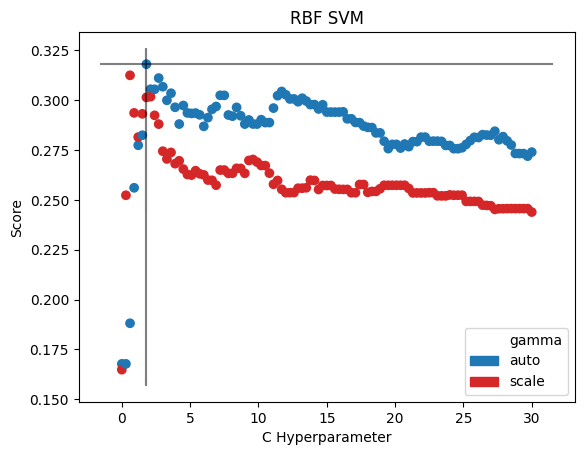

In [ ]:
plot_svm_results(
    gs_svm_rbf, 'RBF SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
        'scale': 'tab:red',
    }
)

there is definitely a peak at low C values: lets narrow down our search

In [ ]:
# 2 min runtime

gs_svm_rbf = svm_gridsearch(
    {
        'svc__kernel': ['rbf'],
        'svc__gamma': ['auto', 'scale'],
    },
    0.00001, 15,
    n = 100, cv = 10,
)

gs_svm_rbf.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_rbf.best_params_, gs_svm_rbf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 2.2500085000000003, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.33303227806653646)

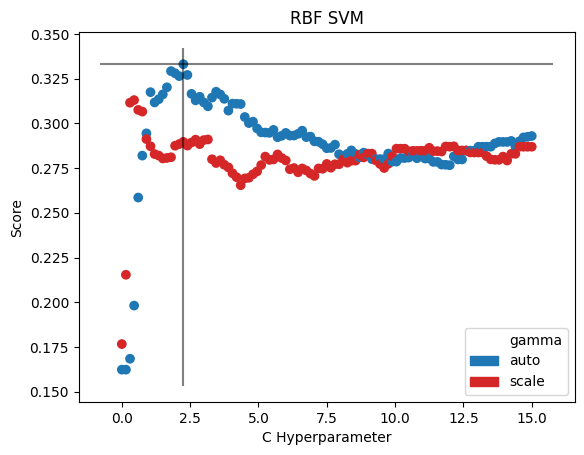

In [ ]:
plot_svm_results(
    gs_svm_rbf, 'RBF SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
        'scale': 'tab:red',
    }
)

We can definitely see that auto gamma is optimal. Lets drop gamma=scale and zoom in on the peak:

In [ ]:
# 60 second runtime

gs_svm_rbf = svm_gridsearch(
    {
        'svc__kernel': ['rbf'],
        'svc__gamma': ['auto'],
    },
    0.1, 4,
    n = 100, cv = 10,
)

gs_svm_rbf.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_rbf.best_params_, gs_svm_rbf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 2.3229999999999995, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.333227256102664)

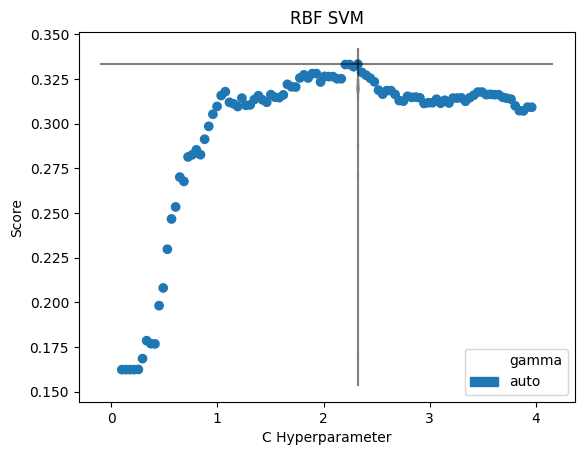

In [ ]:
plot_svm_results(
    gs_svm_rbf, 'RBF SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
    }
)

Now, lets fully zoom in on the peak to fine tune C

In [ ]:
# 55 second runtime

gs_svm_rbf = svm_gridsearch(
    {
        'svc__kernel': ['rbf'],
        'svc__gamma': ['auto'],
    },
    1.9, 2.7,
    n = 100, cv = 10,
)

gs_svm_rbf.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_rbf.best_params_, gs_svm_rbf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 2.2760000000000002, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.3334700145646444)

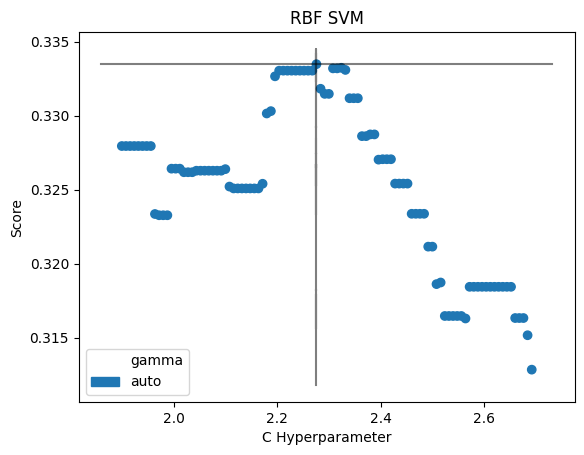

In [ ]:
plot_svm_results(
    gs_svm_rbf, 'RBF SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
    }
)

### 1.3.2.5 SVM: Sigmoid Kernel

In [ ]:
# 2 min runtime

gs_svm_sigmoid = svm_gridsearch(
    {
        'svc__kernel': ['sigmoid'],
        'svc__gamma': ['scale', 'auto'],
    },
    1, 13,
    n = 100, cv = 10,
)

gs_svm_sigmoid.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_sigmoid.best_params_, gs_svm_sigmoid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 3.8800000000000026,
  'svc__gamma': 'auto',
  'svc__kernel': 'sigmoid'},
 0.320843120762654)

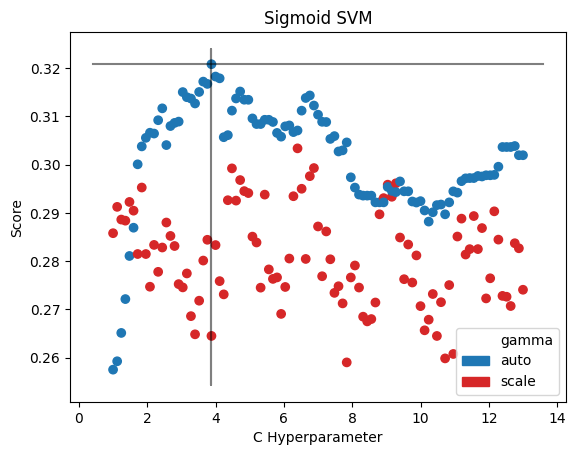

In [ ]:
plot_svm_results(
    gs_svm_sigmoid, 'Sigmoid SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
        'scale': 'tab:red',
    }
)

There is a clear peak around C=4 lets zoom in

In [ ]:
# 120 second runtime

gs_svm_sigmoid = svm_gridsearch(
    {
        'svc__kernel': ['sigmoid'],
        'svc__gamma': ['auto'],
    },
    3.5, 4.5,
    n = 50, cv = 10,
)

gs_svm_sigmoid.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_sigmoid.best_params_, gs_svm_sigmoid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 3.9000000000000004,
  'svc__gamma': 'auto',
  'svc__kernel': 'sigmoid'},
 0.3224206543401876)

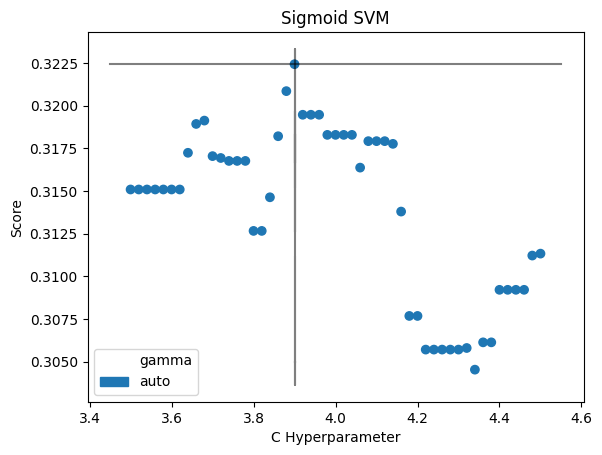

In [ ]:
plot_svm_results(
    gs_svm_sigmoid, 'Sigmoid SVM',
    'param_svc__gamma', {
        'auto': 'tab:blue',
    }
)

### **1.3.2.6 FINAL SVM CONCLUSIONS**

Linear Score 0.3199
- c = 0.0682

Polynomial Score 0.3280
- gamma = auto
- degree = 2
- c = 10.46

**RBF Score 0.3335** <--------------------------- Best
- **gamma = auto**
- **c = 2.282**

Sigmoid Score 0.3224
- gamma = auto
- c = 3.9

In [ ]:
gs_svm_final = svm_gridsearch(
    {
        'svc__kernel': ['rbf'],
        'svc__gamma': ['auto'],
    },
    2.2, 2.4,
    n = 100, cv = 10,
)

gs_svm_final.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_svm_final.best_params_, gs_svm_final.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'svc__C': 2.281999999999991, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.33350031759494747)

## 1.3.3 Logistic Regression Gridsearch

### 1.3.3.0 Helper Functions

In [ ]:
def log_gridsearch(cmin, cmax, n=10,
                   penalty=[None, 'l2', 'l1'], solver = ['saga'],
                   score = 'f1_macro', cv = 2):
    return GridSearchCV(
        estimator = make_pipeline(
            coltrans, LogisticRegression()
        ),
        param_grid = {
            'logisticregression__C': list(frange(cmin, cmax, (cmax-cmin)/n)),
            'logisticregression__penalty': penalty,
            'logisticregression__solver': solver,
        },
        scoring = score,
        cv = cv,
        n_jobs = -1,
        error_score='raise'
    )

In [ ]:
def plot_log_results(gs_obj, title, vlines = [], hlines = []):
    fig = plt.figure()

    colmap = {
        None: 'tab:red',
        'l1': 'tab:blue',
        'l2': 'tab:green',
    }

    x_dat = pd.Series(
        gs_obj.cv_results_['param_logisticregression__C'].data
    )
    y_dat = pd.Series(
        gs_obj.cv_results_['mean_test_score']
    )
    col_dat = pd.Series(
        gs_obj.cv_results_['param_logisticregression__penalty'].data
    ).map(colmap)

    x_mid = (x_dat.max() + x_dat.min()) / 2
    y_mid = (y_dat.max() + y_dat.min()) / 2

    plt.scatter(x=x_dat, y=y_dat, color=col_dat, alpha=0.5)

    for xval in vlines + [gs_obj.best_params_['logisticregression__C']]:
        plt.plot([xval] * y_dat.shape[0], (y_dat-y_mid)*1.1+y_mid,
                 color='black', alpha=0.5)

    for yval in hlines + [gs_obj.best_score_]:
        plt.plot((x_dat-x_mid)*1.1+x_mid, [yval] * x_dat.shape[0],
                 color='black', alpha=0.5)

    plt.title(title)
    plt.xlabel('C Hyperparameter')
    plt.ylabel('Score')
    plt.legend(handles=[mpatches.Patch(color='white', label='penalty')] + [
        mpatches.Patch(color=colmap[key], label=str(key))
        for key in colmap.keys()
    ])

    fig.show()

### 1.3.3.1 Broad Logistic Gridsearch

In [ ]:
# 3 min runtime

gs_log_broad = log_gridsearch(0.0000001, 2, n=100, cv=10)

gs_log_broad.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_log_broad.best_params_, gs_log_broad.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'logisticregression__C': 1.1600000420000005,
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'saga'},
 0.3237785884502698)

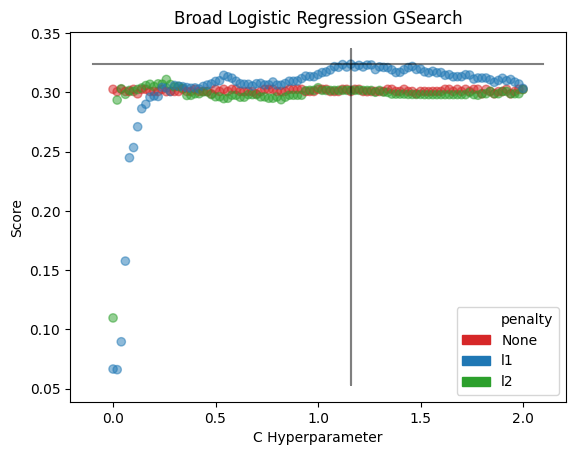

In [ ]:
plot_log_results(gs_log_broad, 'Broad Logistic Regression GSearch')

We can see that l1 is the best penalty option, lets isolate that and zoom in on the peak:

### 1.3.3.2 Fine Logistic Gridsearch

In [ ]:
# 1 min runtime

gs_log_fine = log_gridsearch(0.9, 2, n=100, cv=10, penalty=['l1'])

gs_log_fine.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_log_fine.best_params_, gs_log_fine.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'logisticregression__C': 1.1969999999999983,
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'saga'},
 0.32514960294302336)

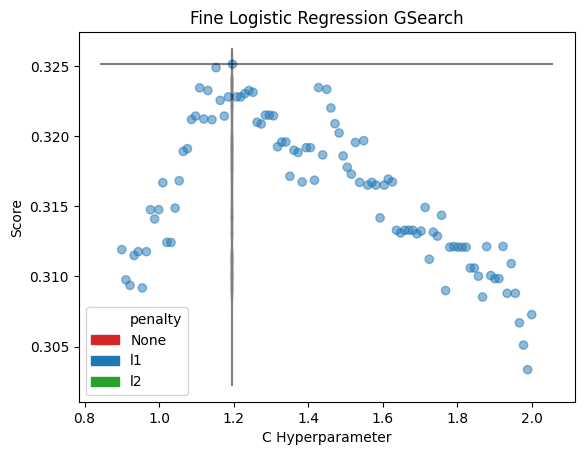

In [ ]:
plot_log_results(gs_log_fine, 'Fine Logistic Regression GSearch')

### **1.3.3.3 FINAL LOGISTIC REGRESSION CONCLUSIONS**

- penalty: l1
- solver: saga
- C: 1.216

Score: 0.3254

In [ ]:
# 1 min runtime

gs_log_final = log_gridsearch(1.1, 1.3, n=100, cv=10, penalty=['l1'])

gs_log_final.fit(df_0001[Xdf.columns], df_0001[Ydf.columns])

(gs_log_final.best_params_, gs_log_final.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'logisticregression__C': 1.2160000000000002,
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'saga'},
 0.3253767306320437)

# 1.4 Model Evaluation and Selection

## 1.4.1 Confusion Matrices for Top Models

### 1.4.1.0 Helper Functions

In [ ]:
def lenient_accuracy(groundtruth, predictions):
    levels = np.unique(groundtruth)
    levels.sort()

    correct = 0
    off = 0
    n = 0

    for (true, pred) in zip(groundtruth, predictions):
        dist = abs(np.where(levels == true)[0][0]
                 - np.where(levels == pred)[0][0])

        correct += 1 - dist / len(levels)
        n += 1

    return (correct + off) / n

In [ ]:
pred_dict = {}

def eval_model(model, title, frame=df):
    id = title + str(df.shape[0])

    if id in pred_dict.keys():
        predictions = pred_dict[id]
    else:
        predictions = model.predict(frame[Xdf.columns])
        pred_dict[id] = predictions

    groundtruth = frame[Ydf.columns[0]].to_numpy()

    print()
    print('MODEL EVALUATION FOR:', title)
    print()
    print('Accuracy Score:', accuracy_score(groundtruth, predictions))
    print('Lenient Accuracy Score:', lenient_accuracy(groundtruth, predictions))
    print()
    print('Precision:', precision_score(groundtruth, predictions, average='weighted'))
    print('Recall:', recall_score(groundtruth, predictions, average='weighted'))
    print('F1 Score:', f1_score(groundtruth, predictions, average='weighted'))
    print()

    levels = pd.Series(df.Severity.unique()).sort_values()

    conf = pd.DataFrame(confusion_matrix(
        groundtruth,
        predictions,
        labels = levels,
        normalize = 'true',
    ), index = levels, columns = levels)

    fig = plt.figure()

    sns.heatmap(conf, annot=True, cmap=sns.color_palette("mako", as_cmap=True))

### 1.4.1.1 KNN Confusion


MODEL EVALUATION FOR: KNN

Accuracy Score: 0.3134398539741398
Lenient Accuracy Score: 0.7603948305107543

Precicion: 0.503007281872139
Recall: 0.3134398539741398
F1 Score: 0.3485440662611073



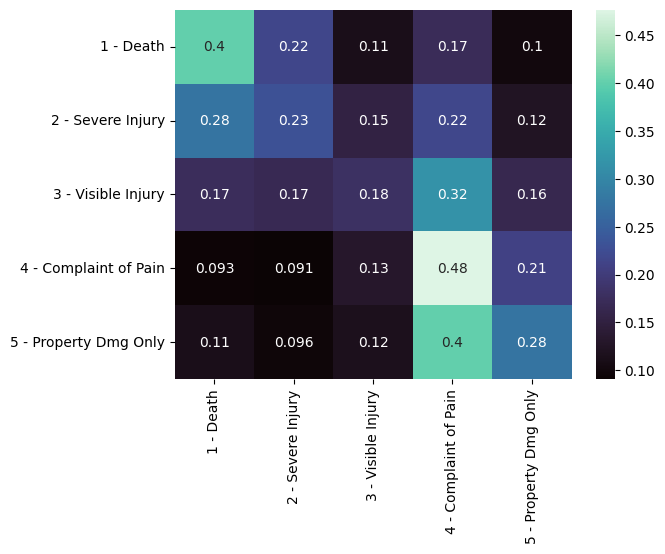

In [ ]:
eval_model(gs_knn_final, 'KNN', frame=df) # 1h runtime

### 1.4.1.2 SVM Confusion


MODEL EVALUATION FOR: SVM

Accuracy Score: 0.26449391108661896
Lenient Accuracy Score: 0.7535127081908097

Precicion: 0.4511406661236101
Recall: 0.26449391108661896
F1 Score: 0.2607855128683388



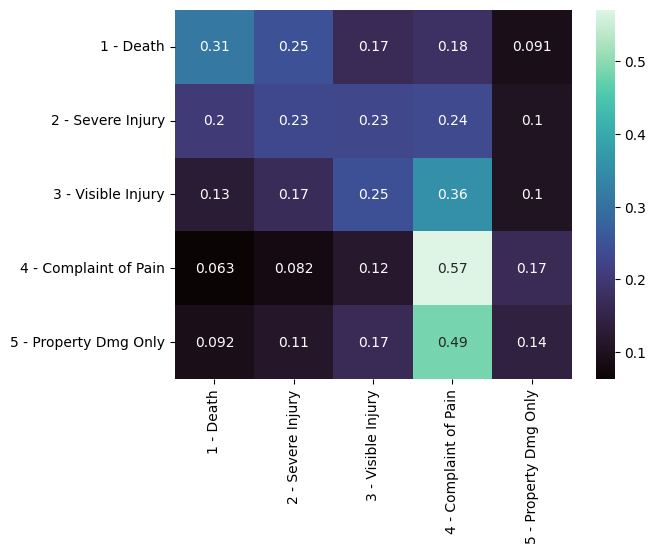

In [ ]:
eval_model(gs_svm_final, 'SVM', frame=df) # 8 min runtime

### 1.4.1.3 Logarithmic Confusion


MODEL EVALUATION FOR: Logarithmic Regression

Accuracy Score: 0.37675506946599946
Lenient Accuracy Score: 0.792184397298857

Precicion: 0.5053937603870164
Recall: 0.37675506946599946
F1 Score: 0.4132342294952799



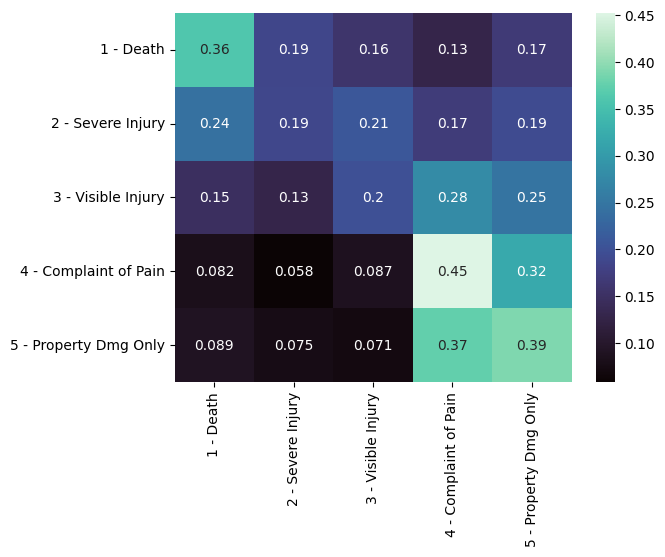

In [ ]:
eval_model(gs_log_final, 'Logarithmic Regression', frame=df) # 5 min runtime

## 1.4.2 Choosing Final Model

In our final evaluation run across the entire dataset we see that logistic regression ends up having the best performance across most of our metrics.

# 1.5 Final Model Visualization